In [1]:
import numpy as np
import pandas as pd
import biovec as bv
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, GridSearchCV, train_test_split
from xgboost import XGBRegressor
from Bio.SeqUtils import MeltingTemp as mt
import os

# Configuration to fix missing paths
os.makedirs("data", exist_ok=True)
os.makedirs("encoders", exist_ok=True)
os.makedirs("models", exist_ok=True)

print("Imports successful and directories created.")

Imports successful and directories created.


## If you have a dataset dont run the below cell

In [15]:
def Tm_molar(seq, dna_conc1, dna_conc2, Na_conc, salt_corr) -> float:
    # Wrapper for BioPython's melting temp calculator
    return mt.Tm_NN(seq, dnac1=dna_conc1*(10**9), dnac2=dna_conc2*(10**9), Na=Na_conc*(10**6), saltcorr=salt_corr)

def gen_rand_seqs(length, amount) -> list:
    return [''.join(np.random.choice(['A','T','G','C'], length)) for i in range(amount)]

def gen_rand_seqs_df(length, amount) -> pd.DataFrame:
    return pd.DataFrame(gen_rand_seqs(length, amount), columns=['seq'])

def gen_rand_seqs_df_Tm(length, amount, dna_conc1, dna_conc2, Na_conc, salt_corr) -> pd.DataFrame:
    """Generates synthetic data with calculated Melting Temps (Ground Truth)"""
    df = gen_rand_seqs_df(length, amount)
    # Calculate Ground Truth Tm using BioPython
    df['Tm'] = df['seq'].apply(lambda x: Tm_molar(x, dna_conc1, dna_conc2, Na_conc, salt_corr))
    return df



In [2]:
# Create a FASTA file for the encoder to train on
def create_fasta(sequences, filename="data/train_corpus.fasta"):
    with open(filename, "w") as f:
        for i, seq in enumerate(sequences):
            f.write(f">seq_{i}\n{seq}\n")
    return filename

In [8]:
class DNAEncoder:
    def encode(self, sequence="AAAAAAA") -> np.ndarray:
        return int(sequence.replace("A", 0).replace("T", 1).replace("G", 2).replace("C", 3), 4)

    def multi_encode(self, sequences) -> list:
        return [self.encode(seq) for seq in sequences]

class ProtVecEncoder(DNAEncoder):
    def __init__(self, model=None, fasta_fname=None, corpus=None, ngram_size=3, vec_dim=64, corpus_fname="corpus.txt", sg=1, window=5, min_count=1, workers=3, method="average", max_len=None):
        
        self.vec_dim = vec_dim
        self.ngram_size = ngram_size
        self.method = method # 'average' or 'pad'
        self.max_len = max_len # Max number of n-grams to keep (if method='pad')
        
        if model is not None and os.path.exists(model):
            self.protvec = bv.models.load_protvec(model)
        else:
            if fasta_fname is None and corpus is None:
                raise Exception("Either fasta_fname or corpus is needed!")
            print(f"Training BioVec on {fasta_fname}...")
            self.protvec = bv.models.ProtVec(fasta_fname=fasta_fname, corpus=corpus, n=ngram_size, size=vec_dim, corpus_fname=corpus_fname, sg=sg, window=window, min_count=min_count, workers=workers)

    def encode(self, seq) -> np.ndarray:
        try:
            # 1. Attempt to get vectors
            vecs = self.protvec.to_vecs(seq)
        except Exception:
            # If biovec crashes on weird sequences, return empty list
            vecs = []

        # 2. FILTER: Ensure we only keep valid numpy arrays of the correct size
        valid_vecs = []
        if vecs:
            for v in vecs:
                if isinstance(v, np.ndarray) and v.shape == (self.vec_dim,):
                    valid_vecs.append(v)
                elif isinstance(v, list) and len(v) == self.vec_dim:
                    valid_vecs.append(np.array(v))
        
        # 3. Handle Encoding based on Method
        if self.method == 'average':
            # Original method: Mean of all vectors
            if len(valid_vecs) == 0:
                return np.zeros(self.vec_dim)
            return np.mean(valid_vecs, axis=0)
            
        elif self.method == 'pad':
            # New method: Pad with zeros to fixed length and flatten
            if self.max_len is None:
                raise ValueError("max_len must be specified for padding method")
                
            # Create empty array of shape (max_len, vec_dim) filled with zeros
            padded = np.full((self.max_len, self.vec_dim), 0)
   
            # Fill with valid vectors up to max_len
            n_vecs = min(len(valid_vecs), self.max_len)
            if n_vecs > 0:
                padded[:n_vecs] = valid_vecs[:n_vecs]
                
            # Flatten to 1D array (size: max_len * vec_dim)
            return padded.flatten()
            
        else:
            raise ValueError(f"Unknown method: {self.method}")
    
    def multi_encode(self, sequences):
        # Convert list of arrays to a single 2D array
        encoded_list = [self.encode(seq) for seq in sequences]
        return np.vstack(encoded_list)

    def save(self, fname) -> None:
        self.protvec.save("encoders/" + fname)

In [ ]:
class TmPredictor():
    def predict(self):
        raise NotImplementedError

class XGBTmPredictor(TmPredictor):
    def __init__(self, model=None, params=None, train_x=None, train_y=None, test_x=None, test_y=None, cv_folds=RepeatedKFold(n_splits=5, n_repeats=1), scoring=['neg_mean_squared_error'], random_state=42):
        
        # CHANGED: Default to CPU to ensure notebook runs everywhere. 
        # Change tree_method to 'gpu_hist' if you have a GPU.
        if model is None:
            model = XGBRegressor(n_estimators=100, max_depth=6, device="cpu", tree_method="hist", random_state=random_state)
        
        self.model = model
        self.params = params if params else {}
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.cv_folds = cv_folds
        self.scoring = scoring
        self.trained = False
        
        if train_x is not None:
            self.hyper_parameter_tune()

    def predict(self, seqs) -> list:
        if not self.trained:
            raise Exception("Model has not been trained!")
        return self.model.predict(seqs)
    
    def hyper_parameter_tune(self) -> None:
        if not self.params:
            # Simplified search space for speed
            self.params = {
                'n_estimators': [50, 100],
                'max_depth': [3, 6],
                'learning_rate': [0.1]
            }
        
        print("Starting Hyperparameter tuning")
        param_tune = GridSearchCV(self.model, self.params, cv=self.cv_folds, scoring='neg_mean_squared_error', refit=True)
        param_tune.fit(self.train_x, self.train_y)
        self.model = param_tune.best_estimator_
        self.trained = True
        print("Tuning complete.")

## Trained the model only on 1 featrue(DNA sequence)

Loaded 640 sequences.
Initializing and training encoder
Max sequence length: 30, Max n-grams: 28
Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress:   0%|          | 0/640 [00:00<?, ?it/s]

corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 13452.31it/s]


Encoding sequences...
Feature shape: (640, 100)
Training XGBoost Predictor
Starting Hyperparameter tuning...
Tuning complete.
Evaluating...
Root Mean Squared Error: 6.7457


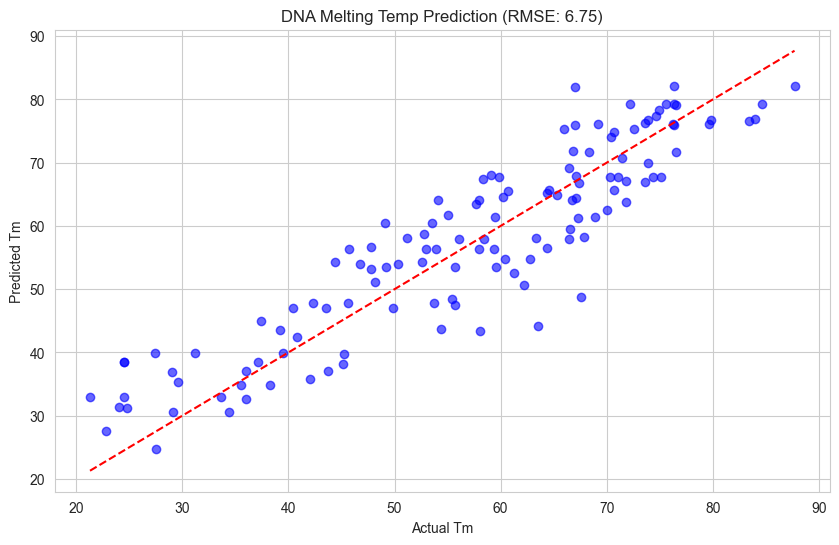

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# --- CONFIGURATION ---
DATA_FILE = "dataset.csv"
SEQ_COL = "Sequence"              
TM_COL = "Experimental Temperature" 
# ---------------------

# 1. LOAD DATASET
df = pd.read_csv(DATA_FILE)

# Standardize column names for the pipeline
df = df.rename(columns={SEQ_COL: 'Sequence', TM_COL: 'Experimental Temperature'})
df = df.dropna(subset=['Sequence', 'Experimental Temperature'])
print(f"Loaded {len(df)} sequences.")

# 2.We need to write the sequences to a FASTA file so biovec can read them
fasta_path = create_fasta(df['Sequence'].tolist())

# 3. TRAIN ENCODER
print("Initializing and training encoder")

# Calculate max length for padding
# Max n-grams = Length - N + 1
# We use a safe upper bound based on the longest sequence in the dataset
max_seq_len = df['Sequence'].apply(len).max()
ngram_size = 3
max_ngrams = max_seq_len - ngram_size + 1
print(f"Max sequence length: {max_seq_len}, Max n-grams: {max_ngrams}")

# Note: If your dataset is huge, 'min_count' can be increased.
# We use method='pad' to fill shorter sequences with zeros
encoder = ProtVecEncoder(fasta_fname=fasta_path, ngram_size=ngram_size, vec_dim=100, min_count=1, workers=2, method = 'average', max_len = max_ngrams)

# 4. PREPARE VECTORS
print("Encoding sequences...")
X = encoder.multi_encode(df['Sequence'])
print(f"Feature shape: {X.shape}")
y = df['Experimental Temperature'].values

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. TRAIN PREDICTOR
print("Training XGBoost Predictor")
predictor = XGBTmPredictor(train_x=X_train, train_y=y_train, test_x=X_test, test_y=y_test)

# 6. EVALUATE
print("Evaluating...")
preds = predictor.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(np.mean((preds - y_test)**2))
print(f"Root Mean Squared Error: {rmse:.4f}")

# Calculate MAE
mae = mean_absolute_error(y_test, preds)

# 7. PLOT RESULTS
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds, alpha=0.6, color='blue')
# Plot diagonal line
line_min, line_max = min(y_test.min(), preds.min()), max(y_test.max(), preds.max())
plt.plot([line_min, line_max], [line_min, line_max], color='red', linestyle='--')

plt.xlabel("Actual Tm")
plt.ylabel("Predicted Tm")
plt.title(f"DNA Melting Temp Prediction (RMSE: {rmse:.2f})")
plt.show()



## Below is the actual Implementation of the Experiment 

Starting experiment with 20 combinations...
Testing Method: average, Dim: 2... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 19375.75it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 7.0403
Testing Method: average, Dim: 4... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 12549.40it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 7.1284
Testing Method: average, Dim: 8... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 13061.22it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 6.7874
Testing Method: average, Dim: 16... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 12309.21it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 6.9824
Testing Method: average, Dim: 24... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 13617.94it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 7.0011
Testing Method: average, Dim: 32... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 13465.20it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 6.7497
Testing Method: average, Dim: 40... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 15236.52it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 6.5970
Testing Method: average, Dim: 48... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 14057.16it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 6.7424
Testing Method: average, Dim: 55... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 14545.56it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 6.6815
Testing Method: average, Dim: 64... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 14547.22it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 6.7083
Testing Method: pad, Dim: 2... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 15238.42it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 7.5589
Testing Method: pad, Dim: 4... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 12922.76it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 7.0580
Testing Method: pad, Dim: 8... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 14548.48it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 7.7389
Testing Method: pad, Dim: 16... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 14222.20it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 7.6596
Testing Method: pad, Dim: 24... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 14375.44it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 7.5216
Testing Method: pad, Dim: 32... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 13188.60it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 7.7669
Testing Method: pad, Dim: 40... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 12810.70it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 7.3031
Testing Method: pad, Dim: 48... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 13756.47it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 7.3595
Testing Method: pad, Dim: 55... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 13188.99it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 7.5869
Testing Method: pad, Dim: 64... Training BioVec on data/train_corpus.fasta...
Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 640/640 [00:00<00:00, 14370.28it/s]


Starting Hyperparameter tuning...
Tuning complete.
RMSE: 7.6359


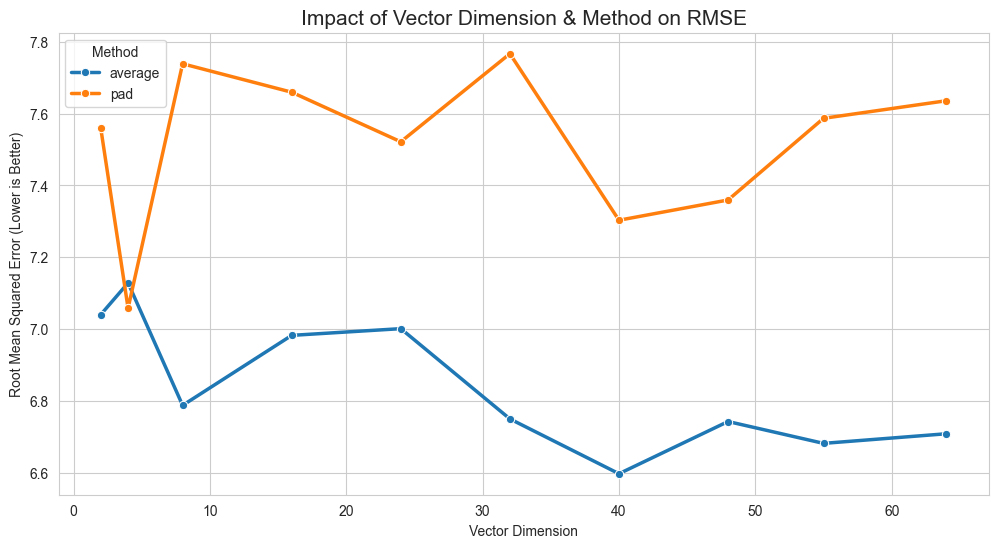

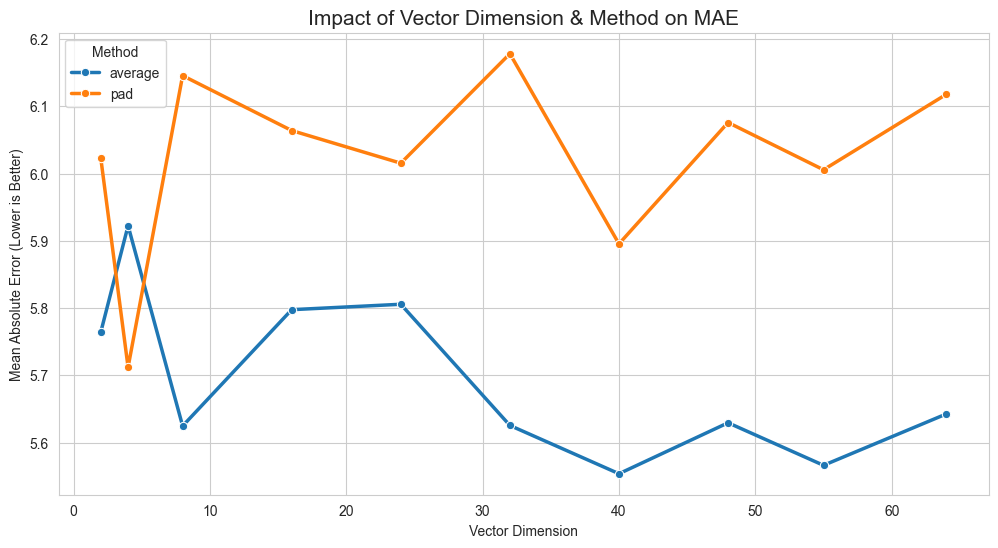

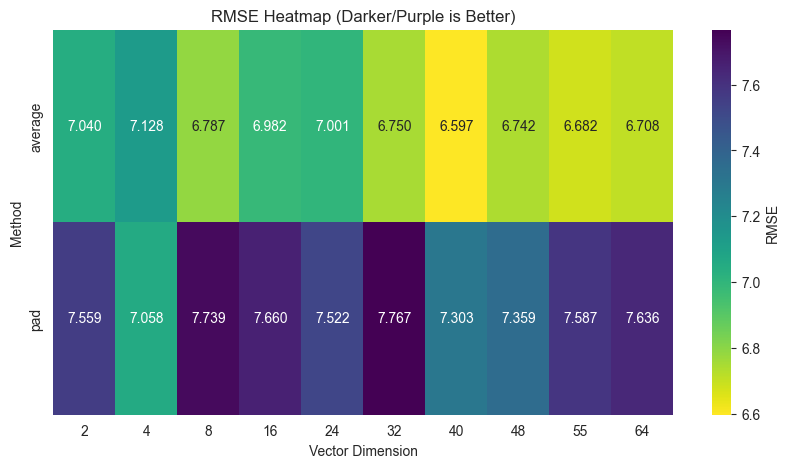


Best Configuration:
Method               average
Vector Dimension          40
RMSE                6.596971
MAE                 5.553623
Name: 6, dtype: object


In [ ]:
import seaborn as sns

# Define the grid of parameters to test
method_types = ["average", "pad"]
vec_dims = [2, 4, 8, 16, 24, 32, 40, 48, 55, 64]
results = []

print(f"Starting experiment with {len(method_types) * len(vec_dims)} combinations...")

for method in method_types:
    for dim in vec_dims:
        print(f"Testing Method: {method}, Dim: {dim}...", end=" ")
        
        # 1. Re-initialize Encoder with specific settings
        # We recalculate max_ngrams to ensure correctness
        max_seq_len = df['Sequence'].apply(len).max()
        ngram_size = 3
        max_ngrams = max_seq_len - ngram_size + 1
        
        # Initialize encoder with current loop parameters
        encoder = ProtVecEncoder(fasta_fname=fasta_path, ngram_size=ngram_size, vec_dim=dim, min_count=1, workers=2, method=method, max_len=max_ngrams)
        
        # 2. Encode Data
        X = encoder.multi_encode(df['Sequence'])
        y = df['Experimental Temperature'].values
        
        # 3. Split Data
        X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # 4. Train & Predict (Using XGBoost for speed in this loop)
        # Note: We suppress print statements from the predictor to keep output clean
        predictor = XGBTmPredictor(train_x=X_train_exp, train_y=y_train_exp, test_x=X_test_exp, test_y=y_test_exp)
        preds = predictor.predict(X_test_exp)
        
        # 5. Calculate Metrics
        rmse = np.sqrt(np.mean((preds - y_test_exp)**2))
        mae = mean_absolute_error(y_test_exp, preds)
        
        print(f"RMSE: {rmse:.4f}")
        
        results.append({
            "Method": method,
            "Vector Dimension": dim,
            "RMSE": rmse,
            "MAE": mae
        })

# Convert results to DataFrame for easy plotting
results_df = pd.DataFrame(results)

# --- VISUALIZATIONS ---
sns.set_style("whitegrid")

# Plot 1: RMSE Comparison
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="Vector Dimension", y="RMSE", hue="Method", marker="o", linewidth=2.5)
plt.title("Impact of Vector Dimension & Method on RMSE", fontsize=15)
plt.ylabel("Root Mean Squared Error (Lower is Better)")
plt.xlabel("Vector Dimension")
plt.show()

# Plot 2: MAE Comparison
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="Vector Dimension", y="MAE", hue="Method", marker="o", linewidth=2.5)
plt.title("Impact of Vector Dimension & Method on MAE", fontsize=15)
plt.ylabel("Mean Absolute Error (Lower is Better)")
plt.xlabel("Vector Dimension")
plt.show()

# Plot 3: Heatmap of RMSE
plt.figure(figsize=(10, 5))
pivot_rmse = results_df.pivot(index="Method", columns="Vector Dimension", values="RMSE")
sns.heatmap(pivot_rmse, annot=True, fmt=".3f", cmap="viridis_r", cbar_kws={'label': 'RMSE'})
plt.title("RMSE Heatmap (Darker/Purple is Better)")
plt.show()

# Display best result
best_run = results_df.loc[results_df['RMSE'].idxmin()]
print("\nBest Configuration:")
print(best_run)